In [1]:
import tensorflow as tf

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd

from tensorflow import keras
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
import random

In [2]:
# plt settings

plt.style.use('default')


plt.rcParams["figure.figsize"] = (14,4)
plt.rcParams['lines.linewidth'] = 1
plt.rcParams["axes.grid"] = True

plt.rcParams["axes.formatter.useoffset"] = False
plt.rcParams["axes.formatter.limits"] = -10000, 10000

### Import marcap_data and preprocess

In [3]:
# import dataset - marcap_data
import os
os.chdir ('/Users/minseok/Documents/GitHub')

from marcap import marcap_data

In [4]:
#Panel Data : Year 2018
df = marcap_data(start = '2018-01-01',end = '2018-12-31')
len(df)

550675

In [5]:
df.head()

,Code,Name,Close,Changes,ChagesRatio,Volume,Amount,Open,High,Low,Marcap,MarcapRatio,Stocks,ForeignShares,ForeignRatio,Rank
Date,,,,,,,,,,,,,,,,
2018-01-02,005930,삼성전자,2551000.0,3000.0,0.1,169485.0,4.326774e+11,2569000.0,2570000.0,2539000.0,3.293303e+14,17.27,129098494.0,68095088.0,52.75,1.0
2018-01-02,000660,SK하이닉스,76600.0,100.0,0.1,2014838.0,1.546792e+11,77300.0,77300.0,76200.0,5.576498e+13,2.92,728002365.0,346184551.0,47.55,2.0
2018-01-02,005935,삼성전자우,2097000.0,7000.0,0.3,21940.0,4.553242e+10,2096000.0,2097000.0,2058000.0,3.827147e+13,2.01,18250580.0,15021675.0,82.31,3.0
2018-01-02,005380,현대차,149500.0,-6500.0,-4.2,731763.0,1.104238e+11,150500.0,153000.0,149000.0,3.293133e+13,1.73,220276479.0,99484123.0,45.16,4.0
2018-01-02,005490,POSCO,339000.0,6500.0,2.0,153013.0,5.161611e+10,335000.0,341000.0,332500.0,2.955634e+13,1.55,87186835.0,48888696.0,56.07,5.0


In [6]:
#Data preprocessing - drop irrelevant columns, reset index to hierarchical
df_1 = df.drop(['Name','Rank'],axis=1).reset_index().set_index(['Code','Date']).sort_index()

### Util Functions

In [7]:
def create_time_steps(length):
  return list(range(-length, 0))

### Class for data process, formatting, model initialization, training, prediction

In [8]:
class Module ():
    def __init__ (self, code, past, future):
        self.code = code
        self.df = df_1.loc[self.code, :].copy(deep = True)
        
        self.past = past #Look back 20 days
        self.future = future #Predict next 6 days
        
    def process (self):
        #adjust the prices
        latest_stocks = self.df.iloc[-1]['Stocks'] # 범위 마지막날 주식수(기준)
        chg_list = ['Close','Changes','Open','High','Low']
        for x in chg_list:
            self.df[x] = self.df[x] * (self.df['Stocks'] / latest_stocks) #Adjusted price
        self.df['Volume'] = self.df['Volume'] * (latest_stocks / self.df['Stocks'])
        self.df.drop(['Stocks','ForeignShares'],axis=1,inplace = True) #Delete misleading cols
        
    def normalize_data(self):
        self.scalar = MinMaxScaler()
        #only use train dataset parts for fitting scalar
        temp_array = self.scalar.fit_transform (self.df.loc[:samsung.valid_dates[self.test_len - 1]])
        self.normalized_df = pd.DataFrame(np.append(temp_array, self.scalar.transform(self.df.loc[samsung.valid_dates[self.test_len]:]), axis = 0))      
        
    def format_data (self):
        #format the data for training
        self.valid_dates = self.df.index.unique()[self.past-1:-(self.future)]
        
        # 3/4 for training, 1/4 for validation
        self.test_len = int(len(self.valid_dates) * (4/5))
        print ("Train_no: {} and Test_no: {}".format(self.test_len,len(self.valid_dates)-self.test_len))
        
        #no. of features
        self.features_count = len(self.df.columns)
        
        self.normalize_data()
        
        #Train data - use normalized df for train data , original df for train label
        self.train_data = np.empty((0,self.past,self.features_count), float)
        self.train_target = np.empty((0,self.future), float)
        for i in range (0, self.test_len):
            self.train_data = np.append(self.train_data, self.normalized_df[i:i+self.past].values.reshape(1,self.past,self.features_count), axis=0)
            self.train_target = np.append(self.train_target, self.df [i+self.past:i+(self.past + self.future)]['Close'].values.reshape(1,self.future), axis = 0)

        #Test data - same
        self.test_data = np.empty((0,self.past,self.features_count), float)
        self.test_target = np.empty((0,self.future), float)
        for i in range (self.test_len, len(self.valid_dates)):
            self.test_data = np.append(self.test_data, self.normalized_df[i:i+self.past].values.reshape(1,self.past,self.features_count), axis=0)
            self.test_target = np.append(self.test_target, self.df [i+self.past:i+(self.past + self.future)]['Close'].values.reshape(1,self.future), axis = 0)
            
    def lstm_model_init (self):
        #initialize and compile LSTM model
        self.model = keras.Sequential()

        self.model.add(keras.layers.LSTM(32, input_shape=(self.past,self.features_count), return_sequences=True))

        self.model.add(keras.layers.LSTM(16, activation = 'relu'))

        self.model.add(keras.layers.Dense(self.future))

        #complile the model
        self.model.compile(optimizer=tf.keras.optimizers.RMSprop(clipvalue=1.0), loss='mae')
        
    def lstm_model_train (self, epoch):
        self.history = self.model.fit(self.train_data,self.train_target, epochs=epoch, verbose=1)
        plt.plot(self.history.history['loss'])
        
    def make_prediction (self, seed = None):
        if (seed is None):
            seed = random.randint(0, len(self.valid_dates)-self.test_len-1)
        print ('Seed : {}'.format(seed))
        
        pred_data = self.test_data[seed].reshape(1,self.past,self.features_count)
        pred_result = self.model.predict(pred_data)
        actual_result = self.test_target[seed]
        
        plt.figure(figsize=(12, 6))    
        num_in = create_time_steps(self.past)
        num_out = self.future
        
        plt.plot(num_in, np.array(self.scalar.inverse_transform(self.test_data[seed]).reshape(self.past,self.features_count)[:,0]), label='History')
        plt.plot(np.arange(num_out), np.array(actual_result).reshape(self.future), 'bo',
               label='True Future')
        plt.plot(np.arange(num_out), np.array(pred_result).reshape(self.future), 'ro',
                 label='Predicted Future')

        plt.legend(loc='upper left')
        plt.show()

### Create Module Object for Samsung Electronics (005930)

In [9]:
samsung = Module (code = '005930', past = 20, future = 5)

In [10]:
samsung.process()

In [11]:
samsung.format_data()

Train_no: 173 and Test_no: 44


In [12]:
print (samsung.train_data.shape)
print (samsung.train_target.shape)

(173, 20, 11)
(173, 5)


In [13]:
samsung.lstm_model_init()

Epoch 1/200
173/173 [==============================] - 4s 21ms/step - loss: 51268.6706
Epoch 2/200
173/173 [==============================] - 1s 4ms/step - loss: 51264.4509
Epoch 3/200
173/173 [==============================] - 1s 4ms/step - loss: 51205.7596
Epoch 4/200
173/173 [==============================] - 1s 4ms/step - loss: 50993.6238
Epoch 5/200
173/173 [==============================] - 1s 4ms/step - loss: 50251.4172
Epoch 6/200
173/173 [==============================] - 1s 5ms/step - loss: 48764.4303
Epoch 7/200
173/173 [==============================] - 1s 4ms/step - loss: 49185.8561
Epoch 8/200
173/173 [==============================] - 1s 4ms/step - loss: 48324.6224
Epoch 9/200
173/173 [==============================] - 1s 4ms/step - loss: 46184.1114
Epoch 10/200
173/173 [==============================] - 1s 4ms/step - loss: 41955.9827
Epoch 11/200
173/173 [==============================] - 1s 4ms/step - loss: 33797.9225
Epoch 12/200
173/173 [=============================

Epoch 96/200
173/173 [==============================] - 1s 4ms/step - loss: 3956.2701
Epoch 97/200
173/173 [==============================] - 1s 4ms/step - loss: 4023.5236
Epoch 98/200
173/173 [==============================] - 1s 4ms/step - loss: 4044.7316
Epoch 99/200
173/173 [==============================] - 1s 4ms/step - loss: 4149.5514
Epoch 100/200
173/173 [==============================] - 1s 4ms/step - loss: 3945.5312
Epoch 101/200
173/173 [==============================] - 1s 6ms/step - loss: 4289.7345
Epoch 102/200
173/173 [==============================] - 1s 6ms/step - loss: 4182.5796
Epoch 103/200
173/173 [==============================] - 1s 4ms/step - loss: 3935.2378
Epoch 104/200
173/173 [==============================] - 1s 5ms/step - loss: 3889.8009
Epoch 105/200
173/173 [==============================] - 1s 4ms/step - loss: 4349.4882
Epoch 106/200
173/173 [==============================] - 1s 5ms/step - loss: 3861.6289
Epoch 107/200
173/173 [========================

173/173 [==============================] - 1s 4ms/step - loss: 4441.9672
Epoch 191/200
173/173 [==============================] - 1s 4ms/step - loss: 4095.4475
Epoch 192/200
173/173 [==============================] - 1s 4ms/step - loss: 4342.7142
Epoch 193/200
173/173 [==============================] - 1s 4ms/step - loss: 4248.0507
Epoch 194/200
173/173 [==============================] - 1s 4ms/step - loss: 4034.1747
Epoch 195/200
173/173 [==============================] - 1s 4ms/step - loss: 4427.6064
Epoch 196/200
173/173 [==============================] - 1s 4ms/step - loss: 4085.0701
Epoch 197/200
173/173 [==============================] - 1s 4ms/step - loss: 4452.8993
Epoch 198/200
173/173 [==============================] - 1s 4ms/step - loss: 4379.9984
Epoch 199/200
173/173 [==============================] - 1s 4ms/step - loss: 4481.6763
Epoch 200/200
173/173 [==============================] - 1s 4ms/step - loss: 4340.4317


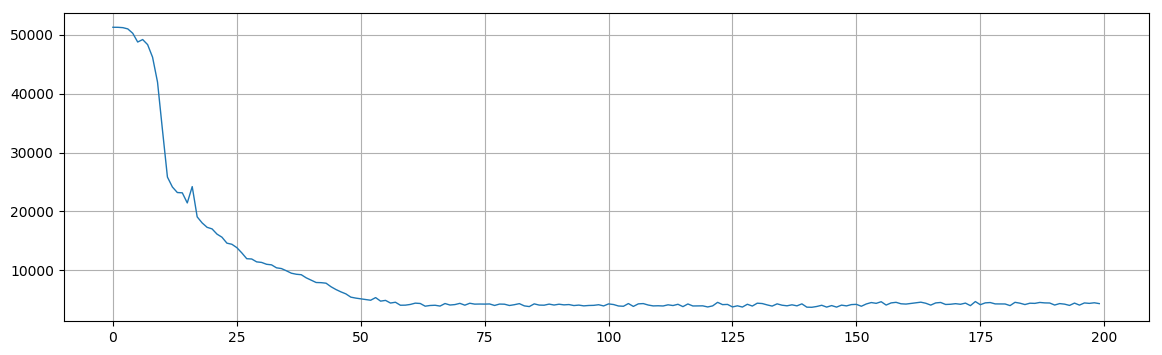

In [14]:
samsung.lstm_model_train(epoch = 200)

Seed : 6


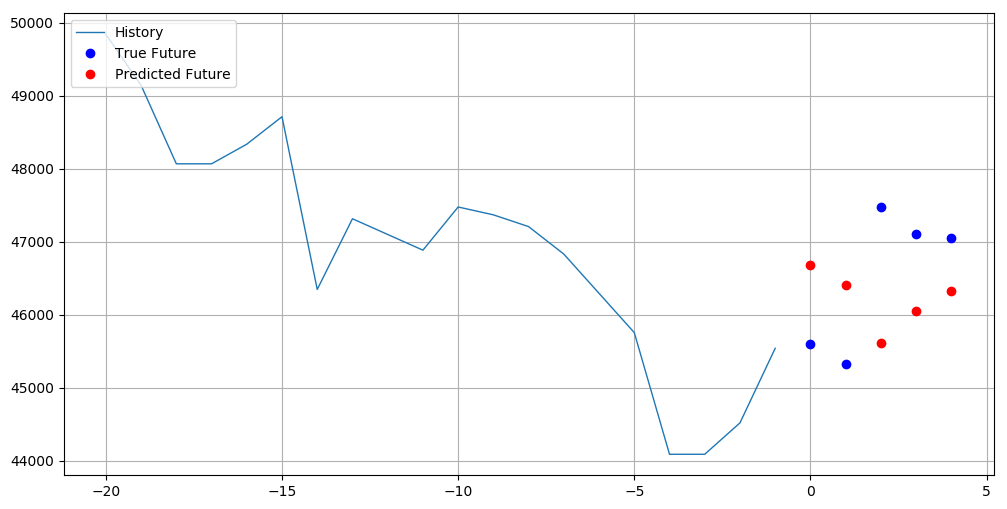

In [22]:
samsung.make_prediction()